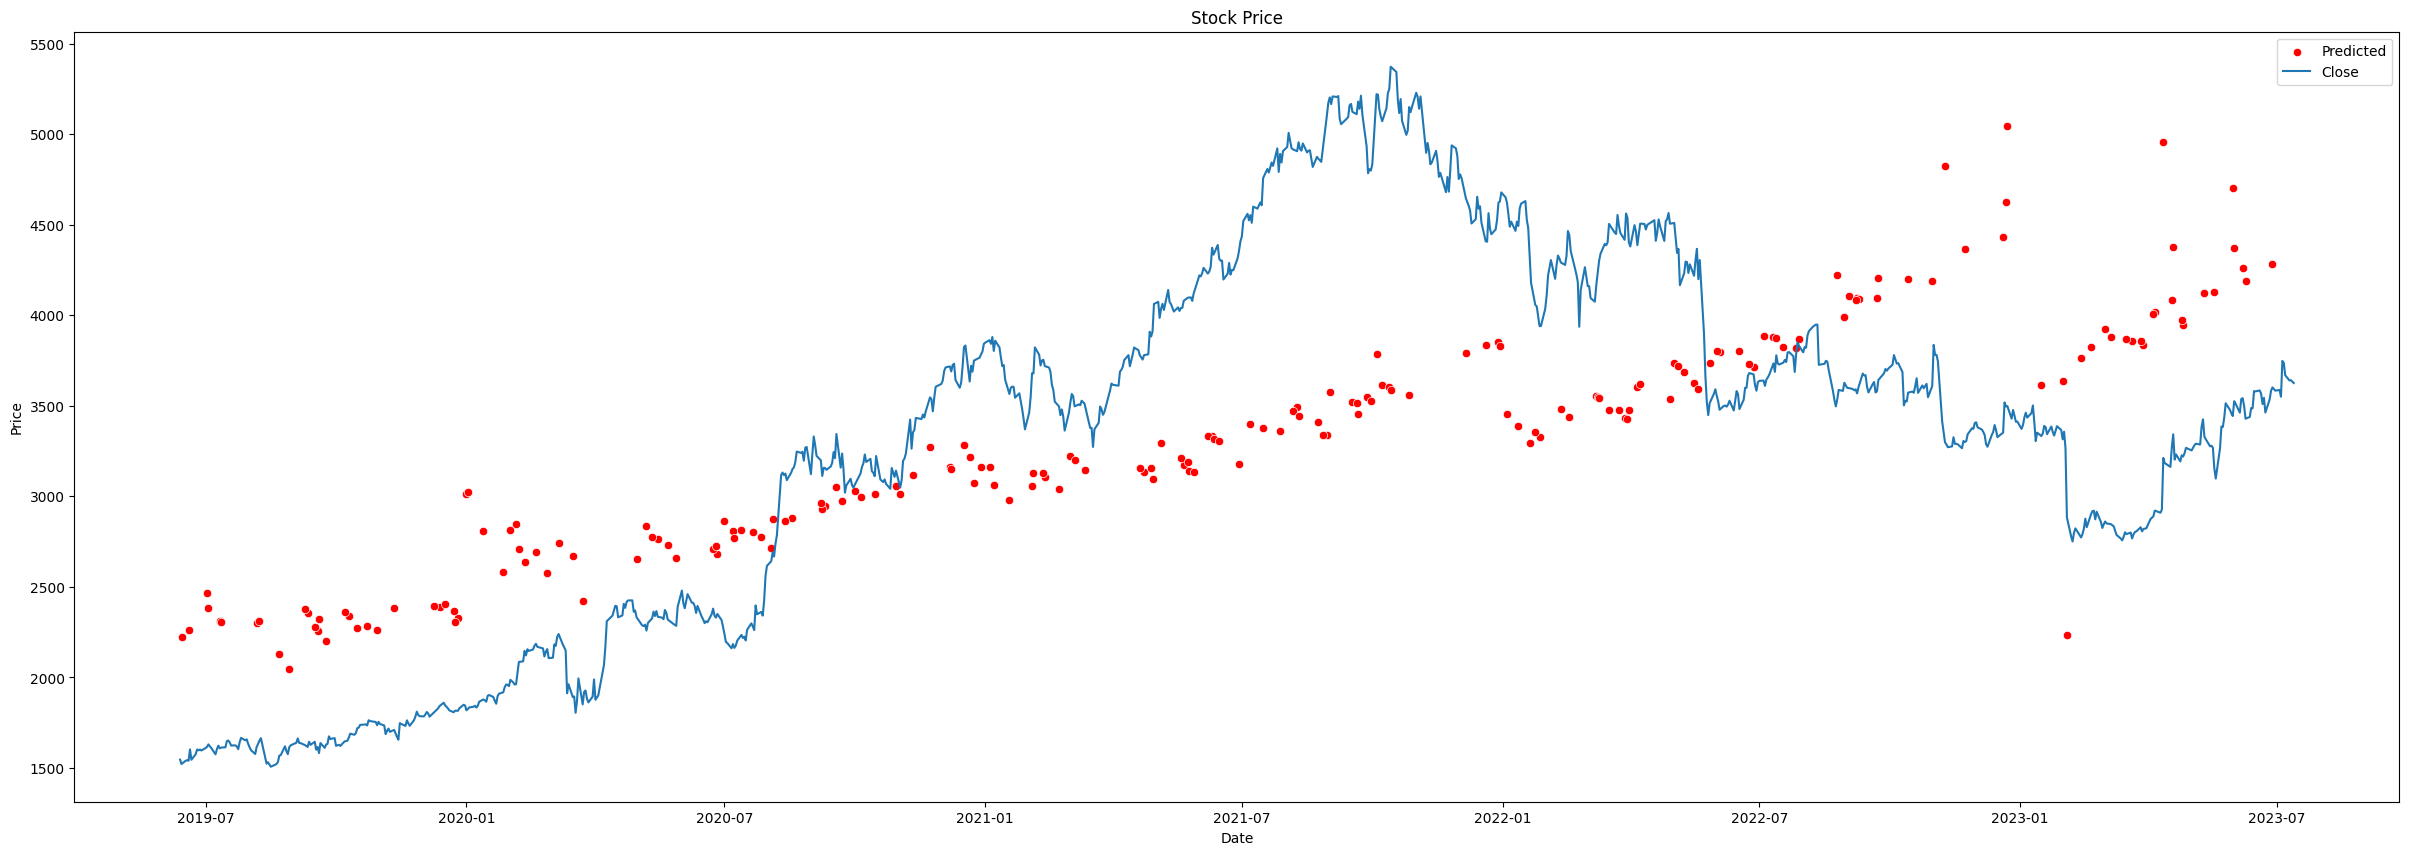

R-squared score: 0.3670091493124402
Adjusted R-squared score: 0.3442864008262201
Actual Buying price: 3687.45
Predicted Selling price: 4260.049694988877
Profit/Loss: 11451.993899777535


C:\Users\kankamra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\kankamra\AppData\Local\Programs\Python\Python311\Lib\site-packages\gspread\worksheet.py:1046: UserWarning: [Deprecated][in version 6.0.0]: method signature will change to: 'Worksheet.update(value = [[]], range_name=)' arguments 'range_name' and 'values' will swap, values will be mandatory of type: 'list(list(...))'
  warnings.warn(


Elapsed time: 1.5416021347045898 seconds


In [2]:
import pandas as pd
import pickle
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
all_data=pd.read_excel('Final.xlsx')


scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('chromatic-pride-392908-ccf371b70a0f.json', scope)
client = gspread.authorize(credentials)

sheet_key = '1-biUonUrbRltqeXIadCUyGpHItCDvljh4JuukYqEODk'
sheet = client.open_by_key(sheet_key)

worksheet = sheet.get_worksheet(0)


stock_name = worksheet.cell(2, 6).value
quantity = int(worksheet.cell(3, 6).value) if worksheet.cell(3, 6).value is not None else 0
buying_date = worksheet.cell(4, 6).value if worksheet.cell(4, 6).value is not None else datetime.datetime.now()
selling_date = worksheet.cell(5, 6).value if worksheet.cell(5, 6).value is not None else datetime.datetime.now()

with open('C:\\Users\\kankamra\\Documents\\Kanika Important\\Models\\linear_regression_model.pkl', 'rb') as file:
    model = pickle.load(file)
    


import pandas as pd
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

start_time = time.time()

# stock_name = input("Enter the stock name:")
# quantity = int(input("Enter the number of stocks:"))
# buying_date = input("Enter the buying date:")
# selling_date = input("Enter the selling date:")

filtered_data = all_data[all_data['Stock_Name'] == stock_name]

filtered_data = filtered_data.copy()
filtered_data['Year'] = filtered_data['Date'].dt.year
filtered_data['Month'] = filtered_data['Date'].dt.month
filtered_data['Day'] = filtered_data['Date'].dt.day
filtered_data.dropna(subset=['Date', 'Year', 'Month', 'Day', 'Volume', 'Chg%', 'Close'], inplace=True)

X = filtered_data[['Volume', 'Chg%', 'Year', 'Month', 'Day']]
y = filtered_data['Close']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train_poly, y_train)
y_pred=model.predict(X_test_poly)
X_test['Predicted'] = pd.Series(y_pred,index=X_test.index)

# Assuming you have a DataFrame named 'data' with the 'Year', 'Month', and 'Day' columns
X_test['Date'] = pd.to_datetime(X_test[['Year', 'Month', 'Day']])

plt.figure(figsize=(30, 10))
sns.scatterplot(x=X_test['Date'], y=X_test['Predicted'], label='Predicted', color='r')
plt.plot(filtered_data['Date'], filtered_data['Close'], label='Close')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price')
plt.legend()
plt.show()




# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared score:", r2)
print("Adjusted R-squared score:", adj_r2)

filtered_data['Date'] = filtered_data['Date'].astype(str)
filtered_data['Date'] = filtered_data['Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

# Convert the buying and selling dates to datetime.date objects
buying_date = datetime.datetime.strptime(buying_date, '%Y-%m-%d').date()
selling_date = datetime.datetime.strptime(selling_date, '%Y-%m-%d').date()

# Get the current date
today_date = datetime.date.today()

# Check the cases and make predictions
if buying_date > today_date and selling_date > today_date:
    # Case 1: Both buying date and selling date in the future
    buying_year = buying_date.year
    buying_month = buying_date.month
    buying_day = buying_date.day
    selling_year = selling_date.year
    selling_month = selling_date.month
    selling_day = selling_date.day

    last_100_data = filtered_data.iloc[-100:]
    volume_mean = np.mean(last_100_data['Volume'])
    chg_mean = np.mean(last_100_data['Chg%'])
    volume_std = np.std(last_100_data['Volume'])
    chg_std = np.std(last_100_data['Chg%'])

    X_buying = np.array([[volume_mean, chg_mean, buying_year, buying_month, buying_day]])
    X_buying_scaled = (X_buying - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
    predicted_close_buying = model.predict(poly.transform(X_buying_scaled))[-1]
    print('Predicted Buying price:', predicted_close_buying)

    X_selling = np.array([[volume_mean, chg_mean, selling_year, selling_month, selling_day]])
    X_selling_scaled = (X_selling - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
    predicted_close_selling = model.predict(poly.transform(X_selling_scaled))[-1]
    print('Predicted Selling price:', predicted_close_selling)

    pnl = (predicted_close_selling - predicted_close_buying) * quantity

elif buying_date > today_date:
    # Case 2: Only buying date in the future
    if selling_date not in filtered_data['Date'].values:
        print("Selling date not found in the dataset.")
        pnl = None
    else:
        buying_year = buying_date.year
        buying_month = buying_date.month
        buying_day = buying_date.day

        last_100_data = filtered_data.iloc[-100:]
        volume_mean = np.mean(last_100_data['Volume'])
        chg_mean = np.mean(last_100_data['Chg%'])
        volume_std = np.std(last_100_data['Volume'])
        chg_std = np.std(last_100_data['Chg%'])

        X_buying = np.array([[volume_mean, chg_mean, buying_year, buying_month, buying_day]])
        X_buying_scaled = (X_buying - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
        predicted_close_buying = model.predict(poly.transform(X_buying_scaled))[-1]
        print('Predicted Buying price:', predicted_close_buying)

        selling_price = filtered_data.loc[filtered_data['Date'] == selling_date, 'Close'].values[0]
        print('Actual Selling price:', selling_price)

        pnl = (selling_price - predicted_close_buying) * quantity

elif selling_date > today_date:
    # Case 3: Only selling date in the future
    if buying_date not in filtered_data['Date'].values:
        print("Buying date not found in the dataset.")
        pnl = None
    else:
        buying_price = filtered_data.loc[filtered_data['Date'] == buying_date, 'Close'].values[0]
        print('Actual Buying price:', buying_price)

        selling_year = selling_date.year
        selling_month = selling_date.month
        selling_day = selling_date.day

        last_100_data = filtered_data.iloc[-100:]
        volume_mean = np.mean(last_100_data['Volume'])
        chg_mean = np.mean(last_100_data['Chg%'])
        volume_std = np.std(last_100_data['Volume'])
        chg_std = np.std(last_100_data['Chg%'])

        X_selling = np.array([[volume_mean, chg_mean, selling_year, selling_month, selling_day]])
        X_selling_scaled = (X_selling - [volume_mean, chg_mean, 0, 0, 0]) / [volume_std, chg_std, 1, 1, 1]
        predicted_close_selling = model.predict(poly.transform(X_selling_scaled))[-1]
        print('Predicted Selling price:', predicted_close_selling)

        pnl = (predicted_close_selling - buying_price) * quantity
else:
    # Case 4: None of the dates are in the future
    if buying_date not in filtered_data['Date'].values:
        print("Buying date not found in the dataset.")
        pnl = None
    elif selling_date not in filtered_data['Date'].values:
        print("Selling date not found in the dataset.")
        pnl = None
    else:
        buying_price = filtered_data.loc[filtered_data['Date'] == buying_date, 'Close'].values[0]
        print('Actual Buying price:', buying_price)

        selling_price = filtered_data.loc[filtered_data['Date'] == selling_date, 'Close'].values[0]
        print('Actual Selling price:', selling_price)

        pnl = (selling_price - buying_price) * quantity


if pnl is not None:
    print("Profit/Loss:", pnl)
    worksheet.update('F7', pnl)
else:
    print("Profit/Loss: None")
    worksheet.update('F7', "None")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
